This file merges together homeless shelter data and the children, youth, and families demographic data. It generates an event-level dataset for the homeless shelter data, with the children, youth, and families demographic data added in.

I then create a few visualizations to help understand this data.

In [22]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
with open('datapath.txt', 'r') as f:
    datapath = f.readlines()[0].strip()

In [24]:
foster_care_path = 'CYF Active 2010 to 2016-11-09(1).csv'

In [25]:
foster_care = pd.read_csv(datapath + foster_care_path)

In [26]:
homeless_path = 'HomelessShelters(1).csv'

In [27]:
homeless = pd.read_csv(datapath + homeless_path)

In [28]:
%ls $datapath

Behavioral Health Services.csv
CYF Active 2010 to 2016-11-09(1).csv
CYF Active 2010 to 2016-11-09.csv
cyf-individual-episodes.csv
cyf_individuals_simplified_race.csv
CYF_placement_mci_id_not_in_cyf_active_file.csv
HomelessShelters(1).csv
IDS Variables.xlsx
RaceReCategorizations_BehavioralDataset.csv
rp_placements_clean.csv


In [29]:
placements = pd.read_csv(datapath + 'rp_placements_clean.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
placement_mcis = placements['MCI_ID'].unique()

Drop CL_ID, should be redundent. Maybe could help merge with other datasets?

In [7]:
foster_care.drop('CL_ID', axis=1, inplace=True)

A bunch of the MCI_ID are zero. This seems to be a wastebasket MCI id

In [8]:
foster_care[foster_care['MCI_ID'] == 0].shape

(6859, 8)

In [31]:
foster_care = foster_care[foster_care['MCI_ID'] > 0.0]

Data dictionary says "Ignore IDs that are less than 10 digits -- those are source system and you will not be able to link". I'm just dropping them.

In [32]:
homeless = homeless[homeless['MCI_ID_OR_HMIS_CLIENT_ID'] >= 1e9]

### Merging in demographic info 

The demographic columns (Birth date, gender, and race) are individual specific and consistent for each entry of the individual. That info is really easy to merge.

In [33]:
demographic_col = [u'BRTH_DT', u'GENDER', u'RACE']

This is an individual-based table of the three demographic factors.

In [34]:
demo_lookup = pd.DataFrame([foster_care.groupby('MCI_ID')[i].unique().map(lambda x: x[0])
                            for i in demographic_col], index=demographic_col).T #There has to be a more pythonic way of doing this

I did an inner join, so I'm going to just have the people that have interacted both with CYF and the shelter system.

This creates a homeless event level dataframe.

In [35]:
homeless_joined = homeless.join(demo_lookup.loc[placement_mcis], on='MCI_ID_OR_HMIS_CLIENT_ID', how='inner')

I didn't convert the dates yet...

In [36]:
dt_episode_start = pd.to_datetime(homeless_joined['PROJ_INVOLVEMENT_EPISODE_START'], errors='coerce')
dt_birth_date = pd.to_datetime(homeless_joined['BRTH_DT'], errors='coerce')

And now I can find the age in years when the homeless episode started.

In [37]:
homeless_joined['age_at_episode_start'] = ((dt_episode_start
                                     - dt_birth_date).dt.days / 365)

In [38]:
homeless_joined['GENDER'].unique()

array(['Female', 'Male', nan], dtype=object)

In [39]:
homeless.groupby('HUD_PROJECT_TYPE')['PROJ_INVOLVEMENT_EPISODE_START'].count() / homeless.shape[0]

HUD_PROJECT_TYPE
Bridge Housing                                                                  0.032338
CMI Bridge                                                                      0.000693
CYF Rental Assist                                                               0.126349
Case Management - HAP                                                           0.032206
Day Shelter                                                                     0.003432
ESG: Homeless Prevention                                                        0.025078
Emergency Shelter                                                               0.290711
HAP Rental Assistance                                                           0.020525
Homelessness Prevention                                                         0.006798
Innovative Program                                                              0.013496
PATH Contingency Funds                                                          0.000132
PATH

In [40]:
homeless_joined.groupby('HUD_PROJECT_TYPE')['PROJ_INVOLVEMENT_EPISODE_START'].count() / homeless_joined.shape[0]

HUD_PROJECT_TYPE
Bridge Housing                  0.027913
CYF Rental Assist               0.192961
Case Management - HAP           0.023058
ESG: Homeless Prevention        0.016990
Emergency Shelter               0.189320
HAP Rental Assistance           0.005461
Homelessness Prevention         0.003034
Innovative Program              0.014563
PATH Contingency Funds          0.000607
PATH Street Outreach            0.001820
Penn Free Bridge                0.010922
Permanent Supportive Housing    0.165049
Rapid Re-Housing                0.035801
Rapid Re-Housing Demo           0.008495
Services Only (SSO)             0.127427
Shelter + Care                  0.026092
Street Outreach                 0.003034
Transitional Housing            0.147451
Name: PROJ_INVOLVEMENT_EPISODE_START, dtype: float64

In [ ]:
placements

In [41]:
homeless_joined['HUD_PROJECT_TYPE'].unique()

array(['CYF Rental Assist', 'Emergency Shelter', 'Services Only (SSO)',
       'Bridge Housing', 'Rapid Re-Housing', 'Transitional Housing',
       'Penn Free Bridge', 'Case Management - HAP', 'Innovative Program',
       'Street Outreach', 'Permanent Supportive Housing',
       'HAP Rental Assistance', 'ESG: Homeless Prevention',
       'Shelter + Care', 'Homelessness Prevention', 'PATH Street Outreach',
       'PATH Contingency Funds', 'Rapid Re-Housing Demo'], dtype=object)

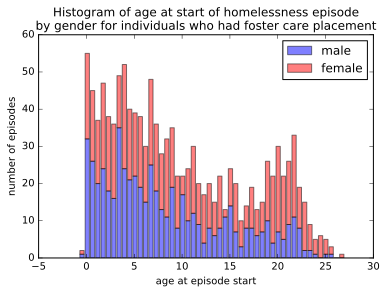

In [49]:

females = homeless_joined[homeless_joined['GENDER'] == 'Female']
males = homeless_joined[homeless_joined['GENDER'] == 'Male']
plt.hist([males['age_at_episode_start'].dropna(),
          females['age_at_episode_start'].dropna()],
         color=['blue', 'red'], label=['male', 'female'],
         stacked=True, bins=50, alpha=0.5)
plt.xlabel('age at episode start')
plt.ylabel('number of episodes')
title = 'Histogram of age at start of homelessness episode\nby gender for individuals who had foster care placement'
plt.title(title)
plt.legend(loc='upper right')
plt.savefig(title.replace(' ', "").replace('\n', '') + '.png')
plt.show()


In [47]:
title.strip() + '.png'

'Histogram of age at start of homelessness episode\nby gender for individuals who had foster care placement.png'

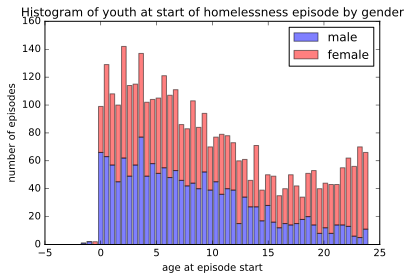

In [21]:
young = homeless_joined[homeless_joined['age_at_episode_start'] <= 24.0]
females = young[young['GENDER'] == 'Female']
males = young[young['GENDER'] == 'Male']
plt.hist([males['age_at_episode_start'].dropna(),
          females['age_at_episode_start'].dropna()],
         color=['blue', 'red'], label=['male', 'female'],
         stacked=True, bins=50, alpha=0.5)
plt.xlabel('age at episode start')
plt.ylabel('number of episodes')
title = 'Histogram of youth at start of homelessness episode by gender'
plt.title(title)
plt.legend(loc='upper right')
plt.savefig(title.strip() + '.png')
plt.show()


In [71]:
pd.to_datetime(not_cyf_homeless['PROJ_INVOLVEMENT_EPISODE_START'], errors='coerce').describe()

count                   23726
unique                   1707
top       2013-11-12 00:00:00
freq                      114
first     2001-07-01 00:00:00
last      2016-11-15 00:00:00
Name: PROJ_INVOLVEMENT_EPISODE_START, dtype: object

In [72]:
pd.to_datetime(homeless_joined['PROJ_INVOLVEMENT_EPISODE_START'], errors='coerce').describe()

count                    6575
unique                   1165
top       2016-07-25 00:00:00
freq                       40
first     2005-05-01 00:00:00
last      2016-11-08 00:00:00
Name: PROJ_INVOLVEMENT_EPISODE_START, dtype: object

In [66]:
not_cyf_homeless.groupby('HUD_PROJECT_TYPE')['PROJ_INVOLVEMENT_EPISODE_START'].count() / not_cyf_homeless.shape[0]

HUD_PROJECT_TYPE
Bridge Housing                                                                  0.032239
CMI Bridge                                                                      0.000885
CYF Rental Assist                                                               0.116187
Case Management - HAP                                                           0.033082
Day Shelter                                                                     0.004214
ESG: Homeless Prevention                                                        0.026761
Emergency Shelter                                                               0.302625
HAP Rental Assistance                                                           0.024485
Homelessness Prevention                                                         0.008302
Innovative Program                                                              0.010536
PATH Contingency Funds                                                          0.000126
PATH